In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201, VGG16, ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.layers import Dense,Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D

In [2]:
import zipfile
import os

zip_path = "Teeth_Dataset.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/Teeth_Dataset")

os.listdir("/content/Teeth_Dataset")


['Teeth_Dataset']

In [3]:
data_train_path = '/content/Teeth_Dataset/Teeth_Dataset/Training'
data_test_path = '/content/Teeth_Dataset/Teeth_Dataset/Testing'
data_val_path = '/content/Teeth_Dataset/Teeth_Dataset/Validation'

In [4]:
img_width = 224
img_height =224
batch_size = 32

In [5]:
data_train = tf.keras.utils.image_dataset_from_directory(
    data_train_path,
    shuffle=True,
    image_size= (img_width,img_height),
    batch_size=32,
    validation_split=False)

Found 3087 files belonging to 7 classes.


In [6]:
data_diseases = data_train.class_names
data_diseases

['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']

In [7]:
data_val = tf.keras.utils.image_dataset_from_directory(
    data_val_path,
    image_size=(img_width, img_height),
    batch_size=32,
    shuffle=False,
    validation_split=False)

Found 1028 files belonging to 7 classes.


In [8]:
data_test = tf.keras.utils.image_dataset_from_directory(
data_test_path,
    image_size=(img_width, img_height),
    shuffle=False,
    batch_size=32,
    validation_split=False
)

Found 1028 files belonging to 7 classes.


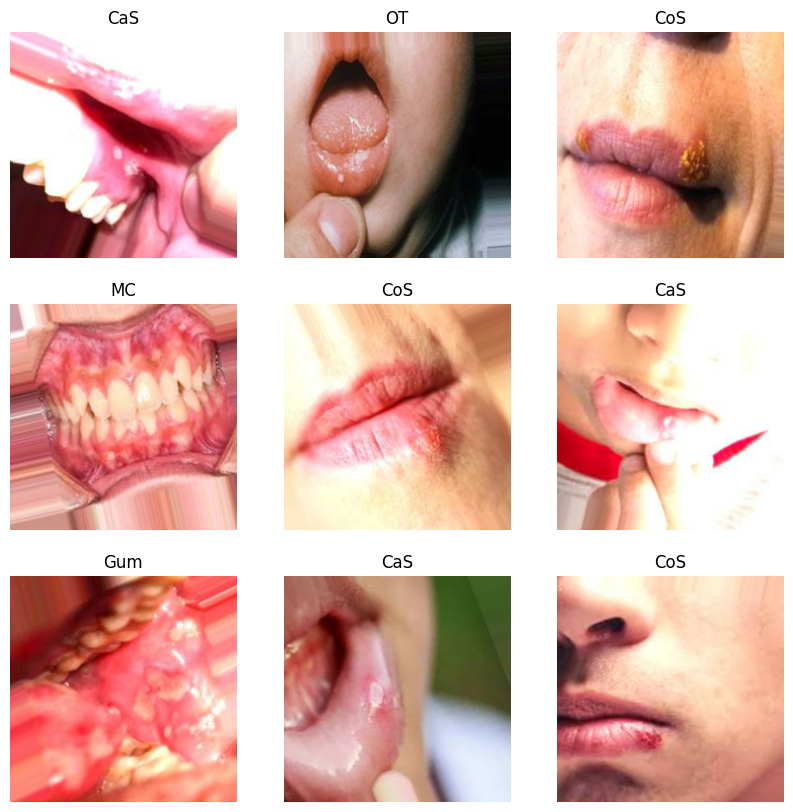

In [9]:
plt.figure(figsize=(10,10))
for image, labels in data_train.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(data_diseases[labels[i]])
        plt.axis('off')

In [10]:
data_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [11]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.2),
])

In [12]:
data_train = data_train.map(lambda x, y: (data_augmentation(x, training=True), y))

In [13]:
y_true = np.concatenate([y for x, y in data_test], axis=0)
y_true[:]

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [14]:
data_train = data_train.prefetch(buffer_size=32)
data_val = data_val.prefetch(buffer_size=32)

In [15]:
def get_callbacks(model_name):
    callbacks =[]

    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'model.{model_name}.keras', verbose=1, monitor='val_loss',mode='min',save_best_only=True)
    callbacks.append(checkpoint)
    anne = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=2, min_lr=0.0000001,min_delta=0.00001,mode='auto')
    callbacks.append(anne)
    earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    callbacks.append(earlystop)

    return callbacks

In [16]:
num_classes=7
OPTIMIZER =Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
base_model = tf.keras.applications.mobilenet.MobileNet(input_shape=(img_width, img_height,3),include_top=False,weights='imagenet')
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(num_classes,name='Final')(x)
model = Model(inputs=base_model.input, outputs=predictions)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,236,039 (12.34 MB)

 Trainable params: 2,402,823 (9.17 MB)

 Non-trainable params: 833,216 (3.18 MB)

In [18]:
model.compile(loss =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer=OPTIMIZER,metrics=['accuracy'])

In [19]:
callbacks = get_callbacks('MobileNet')
history = model.fit(data_train,
                    validation_data= data_val,
                    epochs=30,
                    callbacks=callbacks)

Epoch 1/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.4457 - loss: 1.7079
Epoch 1: val_loss improved from inf to 3.62400, saving model to model.MobileNet.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 85s 607ms/step - accuracy: 0.4467 - loss: 1.7042 - val_accuracy: 0.2802 - val_loss: 3.6240 - learning_rate: 0.0010
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.7251 - loss: 0.8284
Epoch 2: val_loss improved from 3.62400 to 1.76440, saving model to model.MobileNet.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 399ms/step - accuracy: 0.7253 - loss: 0.8276 - val_accuracy: 0.4951 - val_loss: 1.7644 - learning_rate: 0.0010
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.8172 - loss: 0.5203
Epoch 3: val_loss improved from 1.76440 to 1.55704, saving model to model.MobileNet.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 415ms/step - accuracy: 0.8173 - loss: 0.5197 - val_accuracy: 0.5963 - val_loss: 1.5570 - learning_rate: 0.0010
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/ste

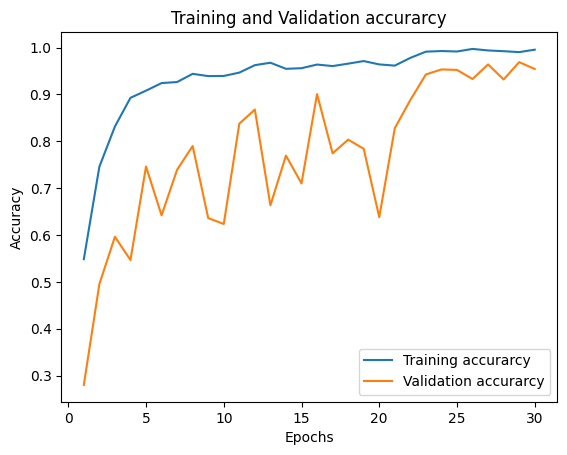

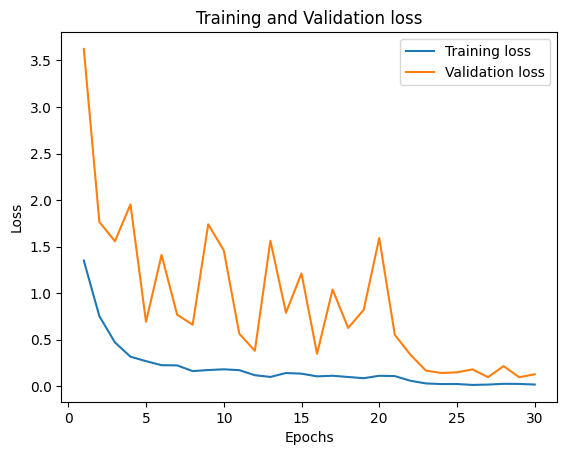

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, label='Training accurarcy')
plt.plot(epochs, val_acc, label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss,  label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(data_test, verbose=2)

print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

33/33 - 1s - 26ms/step - accuracy: 0.9494 - loss: 0.1533
Test Accuracy: 94.94%
Test Loss: 0.1533


In [22]:
#Get predictions
y_pred = model.predict(data_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = np.concatenate([y for x, y in data_test], axis=0)

#Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=data_diseases))

33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step
Classification Report:

              precision    recall  f1-score   support

         CaS       0.99      0.88      0.93       160
         CoS       0.95      1.00      0.97       149
         Gum       0.99      0.97      0.98       120
          MC       0.90      0.97      0.93       180
          OC       0.96      0.92      0.94       108
         OLP       0.92      0.96      0.94       180
          OT       0.99      0.95      0.97       131

    accuracy                           0.95      1028
   macro avg       0.96      0.95      0.95      1028
weighted avg       0.95      0.95      0.95      1028



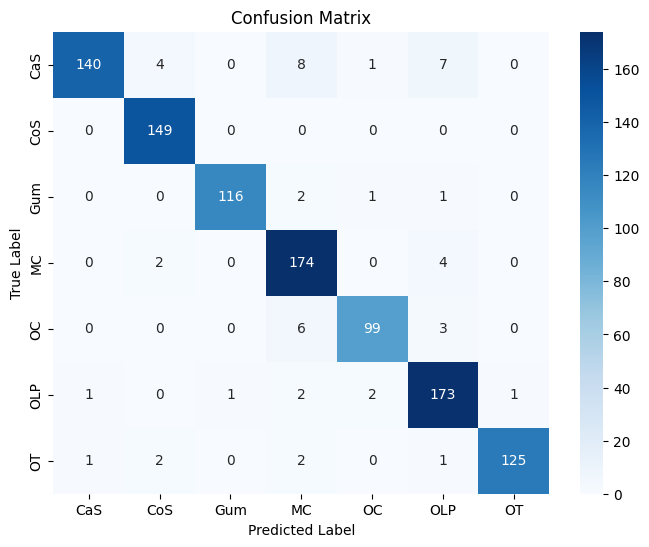

In [23]:
#Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=data_diseases,
            yticklabels=data_diseases)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [24]:
from google.colab import files
files.download('model.MobileNet.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>